# 2.1 张量（中）

在上一节中，我们用回归模型实现了一个简单的函数拟合，同时介绍了一些神经网络的基本概念。在本节，我们将探索神经网络更具有泛化的模型编写，同时实现更多基于pytorch这一由Meta（Facebook母公司）开发的深度学习框架的底层实现（这个框架的所有算法都由c/c++编写，再跟python代码绑定），我们将重点实现这一框架独有的动态图，这一有别于其余深度学习框架（Tensorflow）的静态图的独特实现。

## 数字
首先我们实现一个数字类，这个类有一个更独特的学名：张量（Tensor）

In [1]:
class Tensor:
    def __init__(self, data):
        self.data = data

    def __add__(self, other):
        out = Tensor(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Tensor(self.data * other.data)
        return out
    
    def __repr__(self):
        return f"Tensor(data={self.data})"

我们定义了一个名叫Tensor的类。实现了针对加法和乘法的运算符重载，同时我们还实现了魔术方法\_\_repr\_\_用于打印我们的结果，我们来测试一下这个类：

In [2]:
a = Tensor(12)
b = Tensor(15)
print(a + b)
print(a * b)

Tensor(data=27)
Tensor(data=180)


回顾上一节我们代码实现反向传播的过程，我们都是首先计算一个损失函数，获得以可训练参数作为自变量的函数，然后对每个可训练参数计算偏导数，最后再计算用这个偏导数乘上步长，用来计算这次迭代后可训练参数的结果

同时，根据链式法则，我们并不需要一口气就算出某个可训练参数的偏导数，我们可以用递归的方式逐层求偏导，算出这个可训练参数的偏导数，现在让我们修改这段代码，先算出这些基本运算符的导数，用于后续的递归

In [30]:
class Tensor:
    def __init__(self, data):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None

    def __add__(self, other):
        # 如果被加数还不是Tensor类，就将其转化成Tensor类
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data + other.data)
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        # 如果被乘数还不是Tensor类，就将其转化成Tensor类
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data * other.data)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Tensor(data={self.data})"

(ps: grad是累加的，因为一个Tensor可能被用于计算多个Tensor的值)

让我们来测试一个一个函数f(x)=a*b+c，当a=10,b=5,c=10时，分别计算f(x)对a,b,c的偏导，可以很容易的算出(∂f/∂a) = 5,(∂f/∂b) = 10, (∂f/∂c) = 1

In [31]:
a = Tensor(10)
b = Tensor(5)
c = Tensor(10)
d = a*b
e = d+c
e.grad=1
e._backward()
print(d.grad)
print(c.grad)
d._backward()
print(a.grad)
print(b.grad)

1.0
1.0
5.0
10.0


现在，我们需要实现反向传播算法，我们需要保证算式计算偏导数的先后顺序，我们必须保证在链式法则中，算式中后算的值的偏导数被先算出来。其实熟悉算法的同学应该能知道我们需要用什么算法实现这一功能了，那就是拓扑排序。

## 拓扑排序
在计算机科学领域，有向图的拓扑排序（英语：Topological sorting）或拓扑测序（英语：Topological ordering）是对其顶点的一种线性排序，使得对于从顶点u 到顶点v的每个有向边uv，u 在排序中都在v之前。我们来实现Tensor类的反向传播算法，同时因为我们的反向传播是在整个算式算到最外面开始的，为了确保反向传播的顺序，我们需要在等式计算的时候，记录下通过计算得到当前值的tensor序列，我们用_prev表示

In [32]:
class Tensor:
    def __init__(self, data, _prev=()):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_prev)

    def __add__(self, other):
        # 如果被加数还不是Tensor类，就将其转化成Tensor类
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data + other.data, (self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        # 如果被乘数还不是Tensor类，就将其转化成Tensor类
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data * other.data, (self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
    
        topo = []
        # 记录下已访问过的Tensor集合
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # 因为上面得到的topo序列顺序是反的，所以我们在逐步计算偏导数时需要先进行逆序操作
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __repr__(self):
        return f"Tensor(data={self.data})"

让我们再测试一遍函数f(x)=a*b+c，当a=10,b=5,c=10时，分别计算f(x)对a,b,c的偏导，可以很容易的算出(∂f/∂a) = 5,(∂f/∂b) = 10, (∂f/∂c) = 1

In [33]:
a = Tensor(10)
b = Tensor(5)
c = Tensor(10)
e = a*b+c
e.backward()
print(a.grad)
print(b.grad)
print(c.grad)

5.0
10.0
1.0


现在，我们大体上已经实现了一个Tensor类，我们现在还需要补上激活函数：tanh, sigmoid和relu，以及梯度下降迭代法（就是把之前算出来的梯度按照某种策略对可训练参数进行迭代），同时我们还需要补充左加号,减号和真除等基本魔术方法（参考加法，乘法的实现，不然会报错），让我们的程序可以更好的跑起来，来实现我们上一节的遗留问题

In [14]:
import math
class Tensor:
    def __init__(self, data, _prev=()):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_prev)

    def __add__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data + other.data, (self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data - other.data, (self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad  # Subtract gradient for the other operand
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return (-self).__add__(other)
    
    # 必须重写负号，否则(-self)会报错
    def __neg__(self):
        # Negation operation
        neg_tensor = Tensor(-self.data, (self,))
        def _backward():
            self.grad -= 1.0 * neg_tensor.grad  
        neg_tensor._backward = _backward
        return neg_tensor

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data * other.data, (self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other)
        out = Tensor(self.data / other.data)
        def _backward():
            self.grad += (1 / other.data) * out.grad
            other.grad -= (self.data / (other.data ** 2)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Tensor(t, (self, ))
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def sigmoid(self):
        x = self.data
        s = 1 / (1 + math.exp(-x))
        out = Tensor(s, (self,))

        def _backward():
            self.grad += (s * (1 - s)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        x = self.data
        r = max(0, x)
        out = Tensor(r, (self,))

        def _backward():
            self.grad += (1 if x > 0 else 0) * out.grad
        out._backward = _backward

        return out
    
    def gradient_descent_opt(self, learning_rate=0.001, grad_zero=True):
        for v in self.visited:
            v.data -= learning_rate * v.grad
            if grad_zero:
                v.grad = 0

    def backward(self, ):
        topo = []
        # 记录下已访问过的Tensor集合
        self.visited = set()
        def build_topo(v):
            if v not in self.visited:
                self.visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # 因为上面得到的topo序列顺序是反的，所以我们在逐步计算偏导数时需要先进行逆序操作
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __repr__(self):
        return f"Tensor(data={self.data})"

In [28]:
a = Tensor(10)
b = Tensor(5)
c = Tensor(10)
e = a*b+c
e.backward()
print(a.grad)
print(b.grad)
print(c.grad)
e.gradient_descent_opt()
print(a,a.grad)
print(b,b.grad)
print(c,c.grad)

5.0
10.0
1.0
Tensor(data=9.995) 0
Tensor(data=4.99) 0
Tensor(data=9.999) 0


此外，我们还需要设置，哪些量是可训练的，哪些量是不可训练的，如果一个数被自动转化成Tensor类,那么我们默认是不可训练的数。

In [94]:
import math
class Tensor:
    def __init__(self, data, _prev=(), trainable=True):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_prev)
        self.trainable=trainable

    def __add__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other, trainable=False)
        out = Tensor(self.data + other.data, (self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other, trainable=False)
        out = Tensor(self.data - other.data, (self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad  # Subtract gradient for the other operand
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return (-self).__add__(other)
    
    # 必须重写负号，否则(-self)会报错
    def __neg__(self):
        # Negation operation
        neg_tensor = Tensor(-self.data, (self,))
        def _backward():
            self.grad -= 1.0 * neg_tensor.grad  
        neg_tensor._backward = _backward
        return neg_tensor

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other, trainable=False)
        out = Tensor(self.data * other.data, (self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(other, trainable=False)
        out = Tensor(self.data / other.data, (self, other))
        def _backward():
            self.grad += (1 / other.data) * out.grad
            other.grad -= (self.data / (other.data ** 2)) * out.grad
        out._backward = _backward
        return out
    
    # 必须重写平方项，不能用乘以自身表示平方，否则求导会错
    def __pow__(self, power):
        out = Tensor(self.data ** power, (self,))
        def _backward():
            self.grad += power * (self.data ** (power - 1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Tensor(t, (self, ))
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def sigmoid(self):
        x = self.data
        s = 1 / (1 + math.exp(-x))
        out = Tensor(s, (self,))

        def _backward():
            self.grad += (s * (1 - s)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        x = self.data
        r = max(0, x)
        out = Tensor(r, (self,))

        def _backward():
            self.grad += (1 if x > 0 else 0) * out.grad
        out._backward = _backward

        return out
    
    def gradient_descent_opt(self, learning_rate=0.001, grad_zero=True):
        for v in self.visited:
            if v.trainable:
                v.data -= learning_rate * v.grad
            if grad_zero:
                v.grad = 0

    def backward(self, ):
        topo = []
        # 记录下已访问过的Tensor集合
        self.visited = set()
        def build_topo(v):
            if v not in self.visited:
                self.visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # 因为上面得到的topo序列顺序是反的，所以我们在逐步计算偏导数时需要先进行逆序操作
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __repr__(self):
        return f"Tensor(data={self.data}, trainable={self.trainable})"

我们先测试一个简单的函数，来求解它的神经网络表示

In [202]:
a=Tensor(3)
b=Tensor(2)
def func(x):
    return a*x+b

In [203]:
training_data = [[1,5],[2,6]]

In [204]:
def print_tensor(t, blank=""):
    print(blank+repr(t)+f" grad:{t.grad}")
    for temp in t._prev:
        print_tensor(temp, blank+"----")

In [206]:
epoch = 2000
for i in range(epoch):
    loss = 0
    for data in training_data:
        loss += (func(data[0])-data[1])**2
    loss = loss/len(training_data)
    loss.backward()
    print_tensor(loss)
    loss.gradient_descent_opt(learning_rate=0.1)
    if i % 10 == 0:
        print(f'Epoch {i}/{epoch}, Loss: {loss}')

Tensor(data=1.6320743268117513e-26, trainable=True) grad:1.0
----Tensor(data=2, trainable=False) grad:-8.160371634058757e-27
----Tensor(data=3.2641486536235026e-26, trainable=True) grad:0.5
--------Tensor(data=2.3609818032359662e-26, trainable=True) grad:0.5
------------Tensor(data=0, trainable=False) grad:0.5
------------Tensor(data=2.3609818032359662e-26, trainable=True) grad:0.5
----------------Tensor(data=-1.5365486660812167e-13, trainable=True) grad:-1.5365486660812167e-13
--------------------Tensor(data=5, trainable=False) grad:1.5365486660812167e-13
--------------------Tensor(data=4.999999999999846, trainable=True) grad:-1.5365486660812167e-13
------------------------Tensor(data=3.999999999999598, trainable=True) grad:-5.861977570020827e-14
------------------------Tensor(data=1.0000000000002485, trainable=True) grad:-1.5365486660812167e-13
----------------------------Tensor(data=1.0000000000002485, trainable=True) grad:3.6415315207705135e-14
----------------------------Tensor(da

可以看到，最后a的值被算出是1.0000000000000073，b的值被算出是3.999999999999988，和真值：1，4非常接近，求解成功

现在，让我们用我们本节编写的程序实现上节的遗留问题，我们先制作训练集和测试集，训练集是用于训练模型的，测试集是用于检验模型训练质量的，我们会随机在生成的数据集上选择80个点为训练集，20个点为测试集

In [207]:
def func(x):
    return 4*x*x - 5

In [208]:
import numpy as np

x_values = np.linspace(-10, 10, 30)
y_values = func(x_values)

# Randomly choosing training data
random_indices = np.random.choice(len(x_values), size=20, replace=False)
train_x = x_values[random_indices]
train_y = y_values[random_indices]

# The remaining data can be considered as the testing dataset
test_x = np.delete(x_values, random_indices)
test_y = np.delete(y_values, random_indices)

让我们看看我们制作的训练集和测试集分布

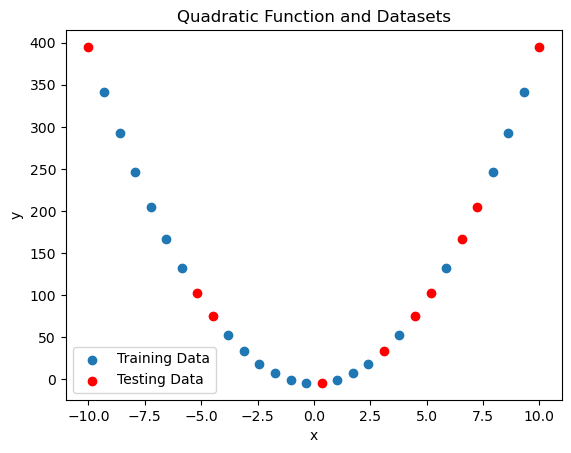

In [209]:
import matplotlib.pyplot as plt

plt.scatter(train_x, train_y, label='Training Data')
plt.scatter(test_x, test_y, color='r', label='Testing Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Function and Datasets')
plt.legend()
plt.show()

In [213]:
import random
w1 = [Tensor(random.random()) for _ in range(10)]
b1 = [Tensor(random.random()) for _ in range(10)]
w2 = [Tensor(random.random()) for _ in range(10)]
b2 = Tensor(random.random())
epoch = 5000
def forward(x):
    temp1 = [w1[i]*x+b1[i] for i in range(len(w1))]
    temp2 = [temp1[i].relu() for i in range(len(temp1))]
    res = 0
    for i in range(len(temp2)):
        res += temp2[i]*w2[i]
    res += b2
    return res
for i in range(epoch):
    loss = 0
    for j in range(len(train_x)):
        y = forward(train_x[j])
        loss += (train_y[j]-y)**2
    loss = loss/len(train_x)
    loss.backward()
    loss.gradient_descent_opt(learning_rate=0.001)
    if i % 100 == 0:
        print(f'Epoch {i}/{epoch}, Loss: {loss}')


Epoch 0/5000, Loss: Tensor(data=29667.183076041892, trainable=True)
Epoch 100/5000, Loss: Tensor(data=2261.7079220398946, trainable=True)
Epoch 200/5000, Loss: Tensor(data=2192.4359649653793, trainable=True)
Epoch 300/5000, Loss: Tensor(data=1999.2738353809282, trainable=True)
Epoch 400/5000, Loss: Tensor(data=1858.7962989816444, trainable=True)
Epoch 500/5000, Loss: Tensor(data=1769.8991241386807, trainable=True)
Epoch 600/5000, Loss: Tensor(data=1703.1538819053744, trainable=True)
Epoch 700/5000, Loss: Tensor(data=1645.5290961473036, trainable=True)
Epoch 800/5000, Loss: Tensor(data=1587.8301749803475, trainable=True)
Epoch 900/5000, Loss: Tensor(data=1560.631974171015, trainable=True)
Epoch 1000/5000, Loss: Tensor(data=1395.1241601882598, trainable=True)
Epoch 1100/5000, Loss: Tensor(data=1340.5904433868836, trainable=True)
Epoch 1200/5000, Loss: Tensor(data=1342.1457495951372, trainable=True)
Epoch 1300/5000, Loss: Tensor(data=1328.19975191992, trainable=True)
Epoch 1400/5000, Loss

In [216]:
def draw(f, test_x, test_y):
    import matplotlib.pyplot as plt
    import numpy as np
    # 生成 x 值范围
    x_values = [i * 0.1 for i in range(int(-10/0.1), int(10/0.1))]
    # 计算对应的 y 值
    y_values = [f(x).data for x in x_values]

    # 绘制图像
    plt.plot(x_values, y_values, label='f(x)')
    plt.title('Graph of f(x)')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格
    plt.scatter(test_x, test_y, label='True data')
    plt.show()

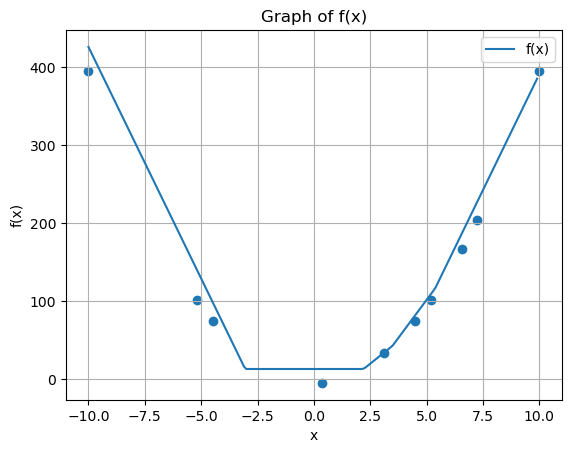

In [217]:
draw(forward, test_x, test_y)

最后我们从本节开始，会附上用标准pytorch实现模型的代码，pytorch将是本教程后面章节的重点，读者可以先熟悉pytorch的代码风格

Epoch 0/1000, Loss: 723.5714111328125
Epoch 100/1000, Loss: 65.84455871582031
Epoch 200/1000, Loss: 51.168853759765625
Epoch 300/1000, Loss: 34.91449737548828
Epoch 400/1000, Loss: 24.89947509765625
Epoch 500/1000, Loss: 24.177091598510742
Epoch 600/1000, Loss: 23.86868667602539
Epoch 700/1000, Loss: 23.467601776123047
Epoch 800/1000, Loss: 20.106321334838867
Epoch 900/1000, Loss: 18.34964370727539


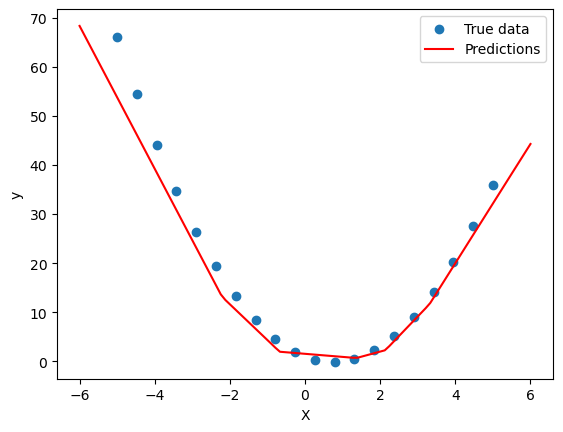

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Define the quadratic function
def quadratic_function(x):
    return 2 * x**2 - 3 * x + 1

# Step 3: Create a dataset
# For simplicity, let's create a dataset with 20 data points between -5 and 5
X_train = torch.linspace(-5, 5, 20).unsqueeze(dim=1)  # Add an extra dimension
y_train = quadratic_function(X_train)

# Step 4: Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Step 5: Define a loss function
criterion = nn.MSELoss()

# Step 6: Train the model
model = SimpleNN()
epochs = 1000

# Step 7: Choose an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(epochs):
    # Forward pass
    predictions = model(X_train)

    # Compute the loss
    loss = criterion(predictions, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Evaluate the trained model
with torch.no_grad():
    X_test = torch.linspace(-6, 6, 100).unsqueeze(dim=1)
    predictions = model(X_test)

# Plot the results
plt.scatter(X_train.numpy(), y_train.numpy(), label='True data')
plt.plot(X_test.numpy(), predictions.numpy(), 'r-', label='Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
